**Importing Useful Libraries**

In [64]:
import cv2
import numpy as np
import math
import sys
import xlrd
from skimage.measure import structural_similarity as ssim
from scipy.stats.stats import pearsonr
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Loading Images from DIBR Dataset**

In [18]:
images=[]
for i in range(1,85,1):
    images.append(cv2.imread("./DIBR_Data/"+str(i)+".png",0));

**Loading Subjective score of images**

In [4]:
loc = ("./DMOS_DIBR.xls"); 
wb = xlrd.open_workbook(loc) 
sheet = wb.sheet_by_index(0) 
dmos=[]
for i in range(0,84,1):
    dmos.append(sheet.cell_value(i, 0)) 

**Counting the number of Black pixels in images with a threshold value of 15.**

In [19]:
geo_distortion=[]
count=[]
for img in images:
    ii=np.empty((len(img),len(img[0])),dtype=np.uint8);
    c=5
    for i in range(0,len(img),1):
        for j in range(0,len(img[0]),1):
            if img[i][j]>15:
                ii[i][j]=255.0;
            else:
                ii[i][j]<=15.0;
                c=c+1;
    geo_distortion.append(ii);
    count.append(c);

**Calculating variance in images using laplacian.**

In [20]:
var_images=[]
var_geo_images=[]
for i in range(0,84,1):
    var_images.append(cv2.Laplacian(images[i], cv2.CV_64F).var())
    var_geo_images.append(cv2.Laplacian(geo_distortion[i], cv2.CV_64F).var())

**Normalizing value of Variance**

In [21]:
norm_images = [float(i)/sum(var_images) for i in var_images]
norm_geo_images = [float(i)/sum(var_geo_images) for i in var_geo_images]

In [22]:
print("PLCC Value obtained by using area covered by black pixels in images\n"+str(abs(pearsonr(count,dmos)[0])))

PLCC Value obtained by using area covered by black pixels in images
0.635551143925


**Images contains blurred region around the edges of object so adjacent columns in images contains almost same pixel value.**

In [23]:
column_count=[]
for img in images:
    c=0
    for j in range(0,len(img[0])-1,1):
        if np.all(np.abs(np.subtract(img[:,j],img[:,j+1]))<25):
            c=c+1
    column_count.append(c)

**Normalizing value of count of black pixels and count of matching columns**

In [24]:
norm_count = [float(i)/sum(count) for i in count]
norm_column_count = [float(i)/sum(column_count) for i in column_count]

# Combining count of black pixels, count of matching columns and variance of image to give PLCC
norm_combine = [5*norm_count[i]+norm_column_count[i]-0.8*norm_images[i] for i in range(0,84,1)]

print("PLCC using 3 attributes of Image: "+str(abs(pearsonr(norm_combine,dmos)[0])))

PLCC using 3 attributes of Image: 0.656470498142


**Applying Gaussian Filter on images and extracting edges and other high frequency information from images.**

In [25]:
gaussian_images=[]
gaussian_images_distorted=[]
for i in range(0,84,1):
    blur = cv2.GaussianBlur(images[i],(3,3),1.25)
    blur_distorted= cv2.GaussianBlur(geo_distortion[i],(3,3),1.25)
    gaussian_images.append(cv2.subtract(images[i],blur));
    gaussian_images_distorted.append(cv2.subtract(geo_distortion[i],blur_distorted));

In [27]:
gaussian_images_sub=[]
sum_gaussian_sub_images=[]
for i in range(0,84,1):
    x=cv2.subtract(gaussian_images[i],gaussian_images_distorted[i])
    gaussian_images_sub.append(x);
    sum_gaussian_sub_images.append(x.sum());

**Applying Median Filter on the image and Computing standard deviation to predict a score.**

In [28]:
med_img = []
for i in range(0,84):
    med_img.append(cv2.medianBlur(images[i], 5))

tmp = []

for i in range(0,84):
    tmp.append(cv2.absdiff(images[i],med_img[i]))

kernel = np.ones((3,3))/9
avg = []
for i in range(0,84):
    avg.append(cv2.filter2D(tmp[i],-1,kernel))

b = []
b1 = []
th = 25
th1 = 45

for i in range(0,84):
    for j in range(0,768):
        for k in range(0,1024):
            if(avg[i][j][k] < th):
                avg[i][j][k] = 0

for i in range(0,84):    
    b.append(np.std(avg[i]))
    
for i in range(0,84):
    for j in range(0,768):
        for k in range(0,1024):
            if(avg[i][j][k] < th1):
                avg[i][j][k] = 0

for i in range(0,84):    
    b1.append(np.std(avg[i]))  

plus=0.001;

score = []

for i in range(0,84):
    score.append((2*b[i]*b1[i]+plus)/(b[i]*b[i]+b1[i]*b1[i]+plus))
    
pearsonr(score,dmos)

(-0.74446793160345981, 4.8000068042222467e-16)

In [63]:
norm_sum_gaussian_sub_images=[float(i)/sum(sum_gaussian_sub_images) for i in sum_gaussian_sub_images]

norm_combination = [4.4*norm_count[i]+1.5*norm_column_count[i]-1.4*norm_images[i]+12*norm_sum_gaussian_sub_images[i]+0.9*score[i] for i in range(0,84,1)]

print("PLCC using 5 attributes of Image: "+str(abs(pearsonr(norm_combination,dmos)[0])))

PLCC using 5 attributes of Image: 0.771414686431


# Explanation:
**In order to compute the Objective score for an Image, we have extracted 5 type of information from images.**
1. Area covered by black geometric distortion in an image.
2. As images gets blurred around the edge of an object we examined that value of pixels remains approximately same to columns near those edges.
3. Using Laplacian to computer variance to get idea about blurness in the image.
4. Extracted Edges and Other High frequency information from the image and used the sum of relevent information.
5. Applied Median Filter on the image and computed standard deviation among images.

Text(0.5,1,u'Image 3 with Edges')

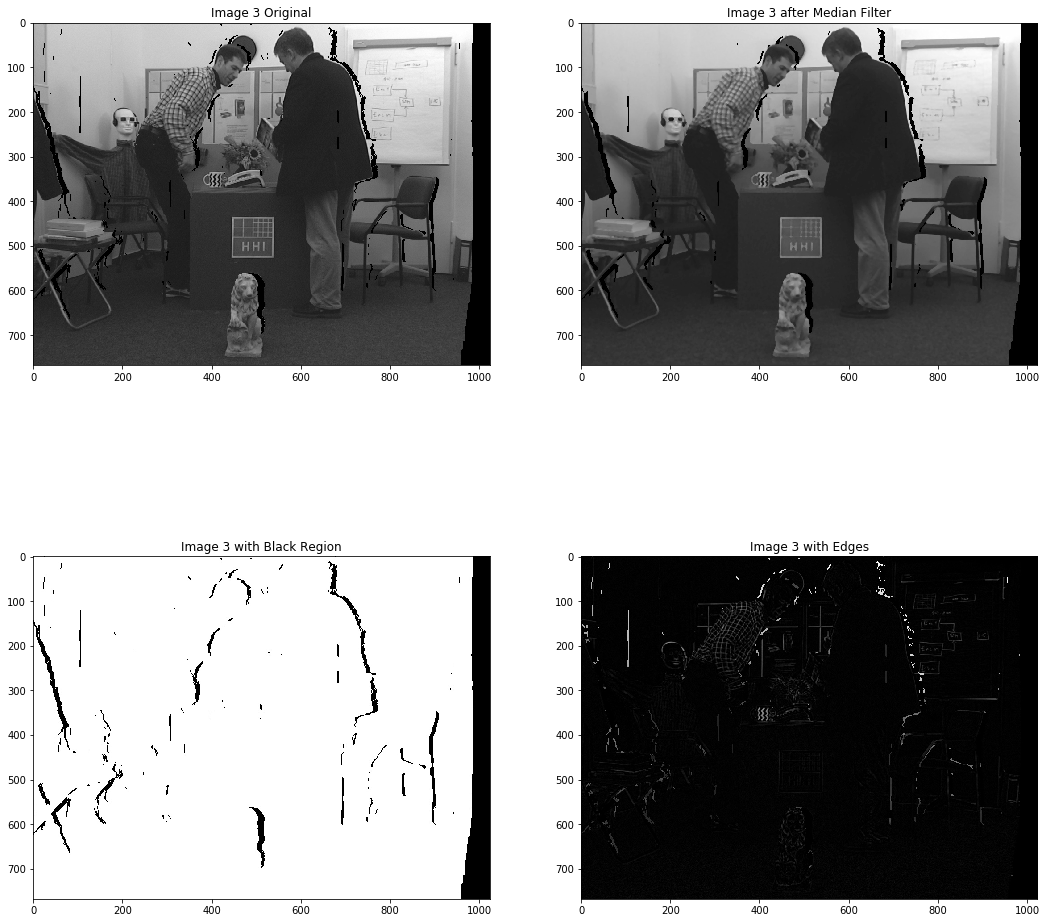

In [72]:
show_img1=images[2];
show_img2=cv2.imread("./3_2.jpg",0);
show_img3=cv2.imread("./3_50903.jpg",0);
show_img4=cv2.imread("./Subtracted_3.jpg",0);



f0, ax0 = plt.subplots(2,2,figsize=(18,18))
ax0[0,0].imshow(images[2],cmap="gray")
ax0[0,0].set_title("Image 3 Original")
ax0[0,1].imshow(show_img2,cmap="gray")
ax0[0,1].set_title("Image 3 after Median Filter")
ax0[1,0].imshow(show_img3,cmap="gray")
ax0[1,0].set_title("Image 3 with Black Region")
ax0[1,1].imshow(show_img4,cmap="gray")
ax0[1,1].set_title("Image 3 with Edges")